## Document classification

Task: Find a list of blogs from any website and find a theme. Use this learning to test if new articles can have be classified into themes as well.

2 models are built:
* Version 1: K-means classify tfidf matrix of the news articles
* Version 2: Supervised learning for news articles categorization 

Skills: nltk, K-means, elbow method, Silhouette Coefficient, tfidf_vectorizer, randomforestclassifier, xgboost, LinearSVC, KNN

## Database from CNN

https://machinelearningmastery.com/prepare-news-articles-text-summarization/

In [1]:
from os import listdir
import string

In [2]:
#Load doc
def load_doc(filename):
    file = open(filename)
    text = file.read()
    file.close()
    return text

In [3]:
# split a doc into story and highlights
def split_story(doc):
    index = doc.find('@highlight')
    story, highlights = doc[:index], doc[index:].split('@highlight')
    highlights = [h.strip() for h in highlights if len(h) > 0]
    return story, highlights

In [4]:
# load all stories in a directory
def load_stories(directory):
    stories = list()
    for name in listdir(directory):
        filename = directory + '/' + name
        doc = load_doc(filename)
        story, highlights = split_story(doc)
        stories.append({'story':story, 'highlights': highlights})
    return stories

### Data Cleaning

In [5]:
def clean_lines(lines):
    cleaned = list()
    # prepare a translation table to remove punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # strip source cnn office if it exists
        index = line.find('(CNN) -- ')
        if index > -1:
            line = line[index+len('(CNN)'):]
        # tokenize on white space
        line = line.split()
        # convert to lower case
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [w.translate(table) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        cleaned.append(' '.join(line))
    # remove empty strings
    cleaned = [c for c in cleaned if len(c) > 0]
    return cleaned

In [6]:
# load stories
directory = 'cnn/stories'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [7]:
# clean stories
for example in stories:
    example['story'] = clean_lines(example['story'].split('\n'))
    example['highlights'] = clean_lines(example['highlights'])

In [8]:
# save to file
from pickle import dump
dump(stories, open('cnn_dataset.pkl', 'wb'))

In [9]:
# load from file
# stories = load(open('cnn_dataset.pkl', 'rb'))
# print('Loaded Stories %d' % len(stories))

In [10]:
articles = stories[0:100]

In [11]:
len(articles)

100

## K-means of all scrambled words

Below method can only cluster all words in the stories

https://www.kaggle.com/thebrownviking20/k-means-clustering-of-1-million-headlines


In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [13]:
articles_combine = []

for i in articles:
    working = ''
    for j in i['story']:
        working += j+'. '
    articles_combine.append(working)

In [14]:
data = pd.DataFrame(articles_combine, columns = ["story"])

In [15]:
data.head()

,story
0,at the start of a big week for the higgs boson...
1,cnngeorge zimmerman acquitted by a florida jur...
2,zlatan ibrahimovic scored his third goal in as...
3,nobel laureate norman e borlaug an agricultura...
4,cnnlouisiana gov bobby jindal on monday stood ...


In [16]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [17]:
from string import punctuation
stop_words = text.ENGLISH_STOP_WORDS.union(punctuation)

In [18]:
stop_words

frozenset({'!',
           '"',
           '#',
           '$',
           '%',
           '&',
           "'",
           '(',
           ')',
           '*',
           '+',
           ',',
           '-',
           '.',
           '/',
           ':',
           ';',
           '<',
           '=',
           '>',
           '?',
           '@',
           '[',
           '\\',
           ']',
           '^',
           '_',
           '`',
           'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
   

In [19]:
desc = data['story'].values

In [20]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
print(len(word_features2))
print(word_features2[:50])

6353
['aaa', 'abandon', 'abbey', 'abc', 'abctv', 'abdelaziz', 'abduct', 'abey', 'abhisit', 'abil', 'abkhazian', 'abl', 'ablaz', 'abov', 'abroad', 'abrupt', 'absenc', 'absolut', 'abstract', 'absurd', 'abu', 'abudu', 'abus', 'abut', 'ac', 'aca', 'academ', 'academi', 'accept', 'access', 'accid', 'acclaim', 'acclimatis', 'accompani', 'accomplish', 'accord', 'account', 'accur', 'accus', 'accustom', 'acer', 'acerb', 'achiev', 'acid', 'acknowledg', 'acquit', 'acquitt', 'act', 'action', 'actionhorror']


In [21]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

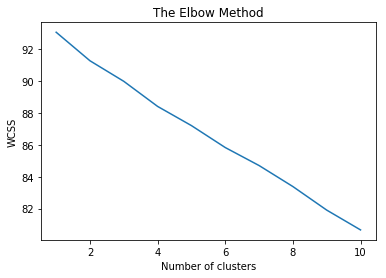

In [22]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.savefig('elbow.png')
plt.show()

In [23]:
kmeans = KMeans(n_clusters = 8, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# Finally, we look at 8 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : health, rajab, care, union, patient, insur, room, parish, emerg, case, said, ministri, say, east, employe, incom, inequ, wait, carrol, rate, doctor, provid, confirm, worker, cost
1 : flight, skiba, plane, land, airport, snow, said, travel, highway, separatist, heavi, passeng, cnn, incid, airlin, richard, injuri, charg, american, offici, detent, press, crew, report, releas
2 : said, just, like, say, make, swift, summum, mother, movi, titl, nare, peopl, think, time, best, play, groupon, im, pillsburi, thor, open, thing, year, blackberri, new
3 : said, polic, offic, protest, govern, peopl, violenc, report, roma, attack, member, shiit, group, new, kill, window, demonstr, year, clement, saturday, monday, particl, arrest, secur, famili
4 : brown, music, probat, leverse, jazz, said, video, therapi, sing, doctor, march, black, diseas, plea, say, hear, brain, file, report, africanamerican, releas, jail, work, serv, record
5 : cup, glass, minut, ahead, fan, second, goal, barcelona, fifa, wor

---

## K-means to categorize articles

TFIDF method

http://seangtkelley.me/blog/2018/01/03/news-article-clustering

In [24]:
articles = stories[0:1000]

In [25]:
articles_combine = []

for i in articles:
    working = ''
    for j in i['story']:
        working += j+'. '
    articles_combine.append(working)

In [26]:
data = pd.DataFrame(articles_combine, columns = ["story"])

data['story'][0]

'at the start of a big week for the higgs boson the most soughtafter particle in all of physics scientists in illinois said monday that they had crept closer to proving that the particle exists but had been unable to reach a definitive conclusion. the scientists outlined their final analysis based on more than years of research and trillion particle collisions using the us department of energys fermilab tevatron collider near batavia illinois whose budgetary woes shut it down last year. what is the higgs boson and why is it important. their announcement came two days before researchers at the large hadron collider under the alps are due to unveil their latest results at an eagerly awaited seminar at the cern particle physics laboratory in geneva switzerland. our data strongly point toward the existence of the higgs boson rob roser a spokesman for one of two independent experiments at the tevatron said in a statement but it will take results from the experiments at the large hadron coll

In [140]:
from sklearn.feature_extraction import text
from string import punctuation

eng_contractions = ["ain't", "amn't", "aren't", "can't", "could've", "couldn't",
                    "daresn't", "didn't", "doesn't", "don't", "gonna", "gotta", 
                    "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", "how'd",
                    "how'll", "how's", "I'd", "I'll", "I'm", "I've", "isn't", "it'd",
                    "it'll", "it's", "let's", "mayn't", "may've", "mightn't", 
                    "might've", "mustn't", "must've", "needn't", "o'clock", "ol'",
                    "oughtn't", "shan't", "she'd", "she'll", "she's", "should've",
                    "shouldn't", "somebody's", "someone's", "something's", "that'll",
                    "that're", "that's", "that'd", "there'd", "there're", "there's", 
                    "these're", "they'd", "they'll", "they're", "they've", "this's",
                    "those're", "tis", "twas", "twasn't", "wasn't", "we'd", "we'd've",
                    "we'll", "we're", "we've", "weren't", "what'd", "what'll", 
                    "what're", "what's", "what've", "when's", "where'd", "where're",
                    "where's", "where've", "which's", "who'd", "who'd've", "who'll",
                    "who're", "who's", "who've", "why'd", "why're", "why's", "won't",
                    "would've", "wouldn't", "y'all", "you'd", "you'll", "you're", 
                    "you've", "'s", "s"
                     ]

custom_stopwords = text.ENGLISH_STOP_WORDS.union(eng_contractions)
custom_stopwords = custom_stopwords.union(punctuation)

In [28]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


In [29]:
import nltk
import re

def tokenize_and_stem(text, do_stem=True):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    # stem filtered tokens
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    if do_stem:
        return stems
    else:
        return filtered_tokens

In [30]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in data['story']:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_and_stem(i, False)
    totalvocab_tokenized.extend(allwords_tokenized)

In [31]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print(len(vocab_frame))
vocab_frame.sample(10)

629690


,words
to,to
are,are
the,the
said,said
constant,constant
of,of
in,in
home,home
saw,saw
when,when


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 min_df = 0.05, stop_words=custom_stopwords,
                                 tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(data['story']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

(1000, 1028)


In [139]:
terms

['abl',
 'abov',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'accus',
 'achiev',
 'acknowledg',
 'act',
 'action',
 'activ',
 'activist',
 'actor',
 'actual',
 'ad',
 'add',
 'addit',
 'address',
 'administr',
 'admit',
 'adult',
 'advanc',
 'affair',
 'affect',
 'affili',
 'africa',
 'afternoon',
 'age',
 'agenc',
 'ago',
 'agre',
 'ahead',
 'aid',
 'aim',
 'air',
 'airport',
 'alleg',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'america',
 'american',
 'amid',
 'angel',
 'ani',
 'announc',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'appar',
 'appeal',
 'appear',
 'approach',
 'approv',
 'april',
 'area',
 'arent',
 'argu',
 'arm',
 'armi',
 'arrest',
 'arriv',
 'ask',
 'assault',
 'assist',
 'associ',
 'attack',
 'attempt',
 'attend',
 'attent',
 'attorney',
 'august',
 'author',
 'avail',
 'averag',
 'avoid',
 'awar',
 'away',
 'bad',
 'ban',
 'bank',
 'barack',
 'barack obama',
 'base',
 'basic',
 'battl',
 'beat',
 'beauti',
 'becam',
 'becaus',
 'becom',
 'bef

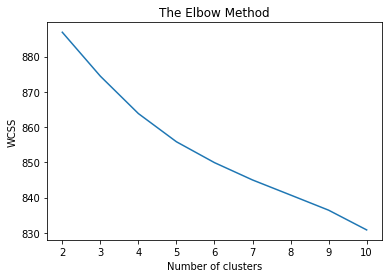

In [33]:
from sklearn.cluster import KMeans
wcss = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(2,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.savefig('elbow.png')
plt.show()

A higher Silhouette Coefficient score relates to a model with better-defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient is for a single sample is then given as:

<img src = 'https://latex.codecogs.com/gif.latex?%24%24s%20%3D%20%5Cfrac%7Bb-a%7D%7Bmax%28a%2Cb%29%7D%24%24'>

Text(0,0.5,'Silhouette Coefficient')

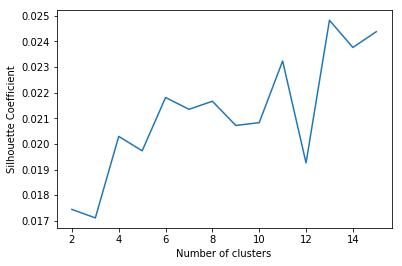

In [34]:
from sklearn import metrics
k_range = range(2,16)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(tfidf_matrix)
    scores.append(metrics.silhouette_score(tfidf_matrix, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [35]:
num_clusters = 13

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [36]:
clusters = km.labels_.tolist()

data['cluster'] = clusters
data.head()

,story,cluster
0,at the start of a big week for the higgs boson...,4
1,cnngeorge zimmerman acquitted by a florida jur...,11
2,zlatan ibrahimovic scored his third goal in as...,5
3,nobel laureate norman e borlaug an agricultura...,1
4,cnnlouisiana gov bobby jindal on monday stood ...,6


In [51]:
len(km.cluster_centers_)

13

In [47]:
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [48]:
print("Top terms per cluster:")
print()

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d stories:" % i, end='')
    print()
    for story in data[data['cluster'] == i]['story'].values.tolist()[0:2]:
        print(' - %s' % story)
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: students, news, cnn, schools, today, college, program, education, said, published,

Cluster 0 stories:
 - a earthquake that struck southwestern china last year left students dead or missing and disabled an additional children state media reported. a girl fastens wish cards at a middle school at qushan township earlier this year in memory of students. the first official tally of students killed in the sichuan province quake was released thursday by tu wentao the head of the provinces education department the xinhua news agency said. as of september official figures put the death toll at with more than people missing the tremor struck may about pm when many children were in school. the official tally of student deaths and injuries was released a few days after an amnesty international report accused the government of china of intimidating and unlawfully detaining relatives of children who had died in the earthquake. the report published sunday doc

Cluster 1 words: said, companies, new, users, video, facebook, web, twitter, site, say,

Cluster 1 stories:
 - nobel laureate norman e borlaug an agricultural scientist who helped develop diseaseresistant wheat used to fight famine in poor countries died saturday he was. norman borlaug received a congressional gold medal from then president george w bush on july. borlaug died from cancer complications in dallas texas a spokeswoman for texas am university said. a recipient of the nobel peace prize borlaug was a distinguished professor of international agriculture at the university. borlaug started at texas am in after working as a scientist in a program that introduced scientific techniques for preventing famine in mexico according to the university. until recently he traveled worldwide working for improvements in agricultural science and food policy said kathleen phillips a university spokeswoman. borlaug was known as a champion of highyield crop varieties and other science and agricul

Cluster 3 words: flight, plane, said, airport, air, traveling, land, fly, board, crews,

Cluster 3 stories:
 - a singleengine airplane made an emergency landing on a california highway sunday morning though no major injuries were reported authorities said. the piper comanche carrying a married couple landed on the southbound lanes of us highway. the piper comanche carrying a married couple landed on the southbound lanes of us highway just outside santa barbara and a few miles from the airport said california highway patrol spokesman officer james richards. the planes engine quit and as the pilot descended he lost control of the plane and landed in the southbound lane facing oncoming traffic the plane struck two vehicles while landing then spun and hit another one with its tail richards said. one vehicle passenger was treated for minor injuries he said no other injuries were reported. the landing happened at am pm et and held up traffic for less than two hours richards said. he added th

Cluster 6 words: said, governments, attack, officials, forcing, reportedly, kill, securing, state, countries,

Cluster 6 stories:
 - cnnlouisiana gov bobby jindal on monday stood by his criticism of socalled nogo zones in europe where sovereign nations allegedly cede authority to muslim immigrants a controversial idea that many critics say is overblown. and the potential republican presidential candidate decried what he called immigrants insistence on nonassimilation the fact that youve got people who want to come to our country but not adopt our values which he called dangerous. jindal has the reputation of policy wonk among republicans and boldly told gop officials during a address to the republican national committee that they must stop being the stupid party and needed to stop insulting the intelligence of voters. asked by cnns wolf blitzer whether he would walk back his comments on nogo zones made in a speech to the henry jackson society in london earlier that day jindal said not 

Cluster 9 words: said, cities, water, storm, home, damaged, miles, areas, people, reportedly,

Cluster 9 stories:
 - at least people died and were hurt when two trains collided in halle on monday a government spokeswoman said. the trains collided headon at am the companies that run the belgian railways and the train said. the cause of the accident is not known according to the railway operator infrabel and sncb the train operator. authorities do not believe there is anyone else on the trains said anya de wols spokeswoman for the province of flemish brabant but they have not ruled out the possibility bodies could be pinned beneath the train cars she said and they plan to lift the cars from the track by tuesday. also on tuesday investigators will collect personal effects such as wallets from the scene to help identify the victims she said. send your pictures videos stories. a belgian government spokesman bart ouvry said it was snowing at the time of the crash but not an unusual amount. p

Cluster 11 words: police, said, office, investigators, police, arrested, charge, case, reportedly, shooting,

Cluster 11 stories:
 - cnngeorge zimmerman acquitted by a florida jury over the death of trayvon martin was arrested in florida on suspicion of aggravated assault and domestic violence with a weapon local authorities said. the florida resident was arrested friday by police in lake mary at about pm and booked into the john e polk correctional facility according to that facilitys website that facility like its website is run by the seminole county sheriffs office. it all came about after zimmerman allegedly threw a wine bottle at a girlfriend his lawyer don west told reporters. whatever happened took place several days ago said west and as far as i know they have not been together for some time certainly not since then. police first learned about it after coming in contact with the alleged victim at a traffic stop on monday lake mary police spokeswoman bianca gillett said. when a

Cluster 12 words: protests, governments, said, minister, demonstrated, president, prime, prime, elected, party,

Cluster 12 stories:
 - russian president dmitry medvedev on tuesday signed a law extending the presidential term the kremlin said in a move many observers believe is designed to bring former president vladimir putin back to the nations top office. some experts believe prime minister vladimir putin remains russias real leader. medvedev putins handpicked successor proposed the changes in november starting with the next president. the new law extends the term of the president from four years to six medvedev also signed a law extending the term of members of the lower house of parliament the duma from four years to five. putin stepped down as president in may after two terms and is now prime minister. earlier this month putin shrugged off the suggestion that medvedev would step down to make way for his return when the law passes. the next election is in he said december accordin

In [39]:
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace

Cluster 0 words: students, news, cnn, schools, today, college, program, education, said, published,
Cluster 1 words: said, companies, new, users, video, facebook, web, twitter, site, say,
Cluster 2 words: obamas, president, said, state, barack, barack, administrator, clintons, president, president,
Cluster 3 words: flight, plane, said, airport, air, traveling, land, fly, board, crews,
Cluster 4 words: said, say, people, like, years, times, just, works, women, making,
Cluster 5 words: win, games, team, player, champions, matches, played, club, football, worlds,
Cluster 6 words: said, governments, attack, officials, forcing, reportedly, kill, securing, state, countries,
Cluster 7 words: film, movie, star, actor, best, book, love, like, story, years,
Cluster 8 words: republican, votes, senate, democratic, elected, obamas, house, party, candidate, campaign,
Cluster 9 words: said, cities, water, storm, home, damaged, miles, areas, people, reportedly,
Cluster 10 words: court, said, sentence,

In [54]:
cluster_dict = {
    0: 'education',
    1: 'social',
    2: 'US politics',
    3: 'travel',
    4: 'supplement',
    5: 'sports',
    6: 'politics',
    7: 'entertainment',
    8: 'politics',
    9: "weather",
    10: "law",
    11: "crime",
    12: "government and protest"
}

In [55]:
data['category'] = data['cluster'].map(cluster_dict)

In [56]:
data.head()

,story,cluster,category
0,at the start of a big week for the higgs boson...,4,supplement
1,cnngeorge zimmerman acquitted by a florida jur...,11,crime
2,zlatan ibrahimovic scored his third goal in as...,5,sports
3,nobel laureate norman e borlaug an agricultura...,1,social
4,cnnlouisiana gov bobby jindal on monday stood ...,6,politics


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
story       1000 non-null object
cluster     1000 non-null int64
category    1000 non-null object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


In [66]:
# data.to_csv('CNN_classified.csv')

In [ ]:
# data = pd.read_csv('CNN_classified.csv', index_col = 0)

# Supervised learning for news articles categorization

In [57]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, string


In [58]:
X = data['story']
y = data['cluster']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [119]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 min_df = 0.05, stop_words=custom_stopwords,
                                 tokenizer=tokenize_and_stem, ngram_range=(1,3),
                                   sublinear_tf = True #do scaling
                                  )

tfidf_vectorizer.fit(X) #fit the vectorizer to synopses
X_train_tfidf_ngram =  tfidf_vectorizer.transform(X_train)
X_test_tfidf_ngram =  tfidf_vectorizer.transform(X_test)

In [120]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

In [121]:
accuracy = train_model(xgboost.XGBClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print("Xgb, N-gram Level TF-IDF: ", accuracy)

Xgb, N-gram Level TF-IDF:  0.7766666666666666


/Users/Kevin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [122]:
accuracy = train_model(ensemble.RandomForestClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print("RF, N-gram Level TF-IDF: ", accuracy)

RF, N-gram Level TF-IDF:  0.6233333333333333


In [134]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Pipeline dictionary
pipelines = {
    'rfc' : make_pipeline(RandomForestClassifier(random_state=123)),
    'xgb' : make_pipeline(XGBClassifier(random_state=123)),
    'svc' : make_pipeline(LinearSVC(random_state=123)),
    'knn' : make_pipeline(KNeighborsClassifier())
}

In [136]:
# # List tuneable hyperparameters of our Logistic pipeline
# pipelines['rf'].get_params()

# Random Forest hyperparameters
rfc_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
}

# Boosted Tree hyperparameters
xgb_hyperparameters = {
    'xgbclassifier__n_estimators': [100, 200],
}


svc_hyperparameters = {},

knn_hyperparameters = {
    'kneighborsclassifier__n_neighbors' : [5,10]
}


# Create hyperparameters dictionary
hyperparameters = {
    'rfc' : rfc_hyperparameters,
    'xgb' : xgb_hyperparameters,
    'svc' : svc_hyperparameters,
    'knn' : knn_hyperparameters
}

In [137]:
# from sklearn.svm import LinearSVC
# from sklearn.datasets import make_classification
# X, y = make_classification(n_features=4, random_state=0)
# clf = LinearSVC(random_state=0, tol=1e-5)
# clf.fit(X, y)

In [138]:
from sklearn.model_selection import GridSearchCV
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train_tfidf_ngram, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

rfc has been fitted.


/Users/Kevin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Kevin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Kevin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Kevin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

xgb has been fitted.
svc has been fitted.
knn has been fitted.
rfc 0.6957142857142857
xgb 0.71
svc 0.8042857142857143
knn 0.7357142857142858


In [128]:
# Predict on test set
pred = fitted_models['svc'].predict(X_test_tfidf_ngram)

# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print('svc test accuracy score: ',metrics.accuracy_score(pred, y_test))
print("confusion_matrix \n", confusion_matrix(y_test, pred) )

svc test accuracy score:  0.8466666666666667
confusion_matrix 
 [[ 2  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 31  0  0  1  1  1  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  3  0  1  0  1  0  0]
 [ 0  0  0  9  0  0  0  1  0  0  0  0  0]
 [ 0  2  3  0 55  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0 27  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0 32  0  1  0  0  1  0]
 [ 0  2  0  0  1  0  0  9  0  1  0  0  0]
 [ 0  0  2  0  1  0  3  0 11  0  0  0  0]
 [ 0  0  0  1  2  0  1  0  0 19  0  3  0]
 [ 0  3  0  0  0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  0  1  0  1  0 22  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  7]]


In [129]:
# test case from test set for prediction
pred = fitted_models['svc'].predict(X_test_tfidf_ngram[0])
type(pred[0])
print("Category: ",cluster_dict[pred[0]])

Category:  sports


In [130]:
X_test.iloc[0]

'inter milan coach jose mourinho will lead his italian team into their first european champions league final in years on may. his task will be to drive inter milan to their first european cup title since by defeating german champions bayern munich at the bernabeu stadium in madrid this saturday. like bayern coach van gaal the is targeting a treble having already secured the italian league and cup titles this year. a victory for the italians would also signal a second treble for mourinho who last achieved the three required victories at porto back in. can mourinho beat van gaal to become king of europe. inters run to the final of the european competition was made all the more impressive with a win over title holders barcelona in the semifinal. record. after promising but brief spells coaching at portuguese sides benfica and uniao de leira mourinho brought home his first silverware while in charge at porto where he claimed the league and cup titles in his first year and treble in the sec